##**Install**

In [ ]:
#Installare gdown
!pip install --quiet gdown

#Scaricare lo ZIP dal DRIVE
!gdown "https://drive.google.com/uc?id=1f8QhG08aikAqoPoVrL5v3-nSS_KAFbHB" -O silkworm_dataset.zip
!unzip -q silkworm_dataset.zip -d silkworm_dataset

Downloading...
From (original): https://drive.google.com/uc?id=1f8QhG08aikAqoPoVrL5v3-nSS_KAFbHB
From (redirected): https://drive.google.com/uc?id=1f8QhG08aikAqoPoVrL5v3-nSS_KAFbHB&confirm=t&uuid=d048c3eb-de4f-4769-90dd-3af21d9616f1
To: /content/silkworm_dataset.zip
100% 3.97G/3.97G [00:50<00:00, 78.7MB/s]
replace silkworm_dataset/__MACOSX/._silk_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace silkworm_dataset/silk_dataset/IMG_2818.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls silkworm_dataset

__MACOSX  silk_dataset


##**Imports**

In [ ]:
import os
import copy
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import torch.nn.functional as F
from sklearn.metrics import silhouette_score, adjusted_rand_score

##**Globals**

In [ ]:
#Paths
data_root = '/content/silkworm_dataset/silk_dataset'
csv_path  = os.path.join(data_root, '0_data.csv')
best_model_path   = 'models/best_mobilenet.pth'
pruned_model_path = 'models/pruned_mobilenet.pth'

#Hyperparameters
batch_size   = 16
lr           = 1e-4
weight_decay = 1e-4
num_classes  = 2
input_size   = (224, 224)
max_epochs   = 10
patience     = 2
prune_amounts = [0.0, 0.1, 0.2]
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##**Utils**

In [ ]:
class SilkwormDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.root, row['foto'])).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(row['classificazione'])
        return img, label

#Early stopping
def early_stop(val_loss, best_val_loss, no_improve, model, path):
    if val_loss < best_val_loss - 1e-4:
        torch.save(model.state_dict(), path)
        return val_loss, 0
    else:
        return best_val_loss, no_improve + 1

#Pruning
def apply_pruning(model, amount):
    params = [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))]
    prune.global_unstructured(params, prune.L1Unstructured, amount=amount)
    for m, _ in params:
        prune.remove(m, 'weight')
    return model

#Pruning Evaluation
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total

def clone_and_prune(orig_model, amount):
    """
    Create a deep copy of the original model and apply global unstructured pruning.
    """
    m = copy.deepcopy(orig_model)
    params = [(module, 'weight') for module in m.modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
    prune.global_unstructured(params, prune.L1Unstructured, amount=amount)
    for module, _ in params:
        prune.remove(module, 'weight')
    return m

#Feature extraction for unsupervised clustering and Sobel filter
def extract_features(model, x):
    x = model.stem(x)
    x = model.stage2(x)
    return x

def sobel_filter(imgs):

    device = imgs.device
    kernel_x = torch.tensor([[1, 0, -1],
                             [2, 0, -2],
                             [1, 0, -1]], dtype=torch.float32, device=device).reshape(1, 1, 3, 3)
    kernel_y = torch.tensor([[1, 2, 1],
                             [0, 0, 0],
                             [-1, -2, -1]], dtype=torch.float32, device=device).reshape(1, 1, 3, 3)

    B, C, H, W = imgs.shape
    edges = torch.zeros_like(imgs)

    for c in range(C):
        channel = imgs[:, c:c+1, :, :]
        grad_x = F.conv2d(channel, kernel_x, padding=1)
        grad_y = F.conv2d(channel, kernel_y, padding=1)
        grad = torch.sqrt(grad_x ** 2 + grad_y ** 2)
        edges[:, c:c+1, :, :] = grad

    return edges

#Clustering evaluation

def evaluate_segmentation_quality(features, labels, method_name):
    try:
        sil_score = silhouette_score(features, labels)
        counts = np.bincount(labels)
        cluster_balance = np.std(counts) / np.mean(counts)

        print(f"\n{method_name} Results:")
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"  Clusters: {len(np.unique(labels))}")
        print(f"  Cluster Balance: {cluster_balance:.4f}")

        return {
            'silhouette_score': sil_score,
            'n_clusters': len(np.unique(labels)),
            'cluster_balance': cluster_balance
        }
    except Exception as e:
        print(f"Error in {method_name}: {e}")
        return None

def compare_methods(results_dict):
    print("\n" + "="*50)
    print("SEGMENTATION COMPARISON")
    print("="*50)
    best_method = max(
        ((m, r['silhouette_score']) for m, r in results_dict.items() if r),
        key=lambda x: x[1],
        default=(None, -1)
    )
    for m, r in results_dict.items():
        if r:
            print(f"{m:15} | Silhouette: {r['silhouette_score']:.4f} | Clusters: {r['n_clusters']:2d} | Balance: {r['cluster_balance']:.3f}")
    print("="*50)
    if best_method[0]:
        print(f"Best Method: {best_method[0]} (Score: {best_method[1]:.4f})")
    print("="*50)
    return best_method[0]

##**Data**

In [ ]:
#Transforms
dataset_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

#Dataset and split data
dataset = SilkwormDataset(csv_path, data_root, transform=dataset_transform)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True),
    'val':   DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
}

#Dataloader for unsupervised clustering
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

##**Network**

###Mobilenet_v2

In [ ]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

###MobileViT

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size=1, stride=1, padding=0, groups = 1, activation = nn.SiLU):
    super().__init__()
    self.in_ch = in_ch
    self.out_ch = out_ch
    self.stride = stride
    self.activation = activation() if activation is not None else nn.Identity()
    self.block = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size, stride = stride, padding = padding, groups = groups),
        nn.BatchNorm2d(out_ch),
        self.activation
    )

  def forward(self, x):
    return self.block(x)


class ResBlock_Inverted(nn.Module):
  def __init__(self, in_ch, out_ch, stride, expansion = 6):
    super().__init__()
    self.in_ch = in_ch
    self.out_ch = out_ch
    self.expansion = expansion
    hidden_ch = in_ch * expansion

    #Expansion
    if stride == 1 and in_ch == out_ch:
      self.residual = True
    else:
      self.residual = False

    self.block = nn.Sequential(
        ConvBlock(in_ch, hidden_ch, kernel_size = 1, padding = 0),
        ConvBlock(hidden_ch, hidden_ch, kernel_size = 3, padding = 1, groups = hidden_ch),
        ConvBlock(hidden_ch, out_ch, kernel_size = 1, padding = 0, activation = None)
    )

  def forward(self, x):
    if self.residual:
      return x + self.block(x)
    else:
      return self.block(x)


class PatchEmbedding(nn.Module):
  def __init__(self, in_ch, embed_dim, patch_size):
    super().__init__()
    self.patch = nn.Conv2d(in_ch, embed_dim, kernel_size = patch_size, stride = patch_size)
    self.flatten = nn.Flatten(2)

  def forward(self, x):
    x = self.patch(x)          # [B, embed_dim, H/ps, W/ps]
    x = self.flatten(x)        # [B, embed_dim, N]
    x = x.transpose(1, 2)      # [B, N, embed_dim]
    return x

class Transformer(nn.Module):
  def __init__(self, dim, heads):
    super().__init__()
    self.atten_layer = nn.MultiheadAttention(embed_dim = dim, num_heads = heads, batch_first = True)
    self.norm1 = nn.LayerNorm(dim)
    self.mlp = nn.Sequential(
        nn.Linear(dim, dim * 2),
        nn.GELU(),
        nn.Linear(dim * 2, dim)
    )
    self.norm2 = nn.LayerNorm(dim)

  def forward(self, x):
    atten_out, _ = self.atten_layer(x, x, x) #atten_layer -> atten_output, atten_weights. I only want atten_out
    x = self.norm1(x + atten_out)
    x = self.norm2(x + self.mlp(x))
    return x

class MobileViT_Block(nn.Module):
  def __init__(self, in_ch, trans_dim, patch_size, heads):
    super().__init__()
    self.feature_extr = nn.Sequential(
        ConvBlock(in_ch, in_ch, kernel_size = 3, padding = 1),
        ConvBlock(in_ch, trans_dim, kernel_size = 1)
    )

    self.patch_embedding = PatchEmbedding(in_ch = trans_dim, embed_dim = trans_dim, patch_size = patch_size)
    self.transformer = Transformer(dim = trans_dim, heads = heads)
    self.output_proj = nn.Sequential(
        ConvBlock(trans_dim, in_ch, kernel_size = 1),
        ConvBlock(in_ch, in_ch, kernel_size = 3, padding = 1)
    )

    self.patch_size = patch_size

  def forward(self, x):
    y = self.feature_extr(x)   # [B, d, H, W], d = trans_dim
    B, C, H, W = y.shape
    Ph = Pw = self.patch_size
    y_seq = self.patch_embedding(y)  # [B, N, dim], N = H x W
    y_seq = self.transformer(y_seq)
    H_, W_ = H // Ph, W // Pw
    y = y_seq.view(B, H_, W_, -1).permute(0, 3, 1, 2).contiguous()
    out = self.output_proj(y)
    return out

class MobileViT(nn.Module):
  def __init__(self, num_classes = 2):
    super().__init__()
    self.stem = nn.Sequential(
        ConvBlock(3, 16, kernel_size = 3, stride = 2, padding = 1),
        ResBlock_Inverted(16, 16, stride = 1)
    )

    self.stage2 = ResBlock_Inverted(16, 24, stride=2)
    self.stage3 = MobileViT_Block(24, trans_dim=64, patch_size=2, heads = 4)
    self.stage4 = MobileViT_Block(24, trans_dim=80, patch_size=2, heads = 4)
    self.stage5 = MobileViT_Block(24, trans_dim=96, patch_size=2, heads = 4)

    self.pool = nn.AdaptiveAvgPool2d(1)
    self.classifier = nn.Linear(24, num_classes)

  def forward(self, x):
    x = self.stem(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    x = self.pool(x).view(x.size(0), -1)
    return self.classifier(x)

model = MobileViT().to(device)
model.eval()

MobileViT(
  (stem): Sequential(
    (0): ConvBlock(
      (activation): SiLU()
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
    (1): ResBlock_Inverted(
      (block): Sequential(
        (0): ConvBlock(
          (activation): SiLU()
          (block): Sequential(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU()
          )
        )
        (1): ConvBlock(
          (activation): SiLU()
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU()
          )
        )
        (2): C

##**Training**

Epoch 01  Train Loss: 0.4254  Val Loss: 0.2650  Val Acc: 91.51%
Epoch 02  Train Loss: 0.2948  Val Loss: 0.2260  Val Acc: 95.94%
Epoch 03  Train Loss: 0.2489  Val Loss: 0.1756  Val Acc: 96.68%
Epoch 04  Train Loss: 0.2326  Val Loss: 0.1857  Val Acc: 95.94%
Epoch 05  Train Loss: 0.2183  Val Loss: 0.1567  Val Acc: 96.68%
Epoch 06  Train Loss: 0.1897  Val Loss: 0.2249  Val Acc: 94.46%
Epoch 07  Train Loss: 0.1817  Val Loss: 0.1400  Val Acc: 97.42%
Epoch 08  Train Loss: 0.1372  Val Loss: 0.1782  Val Acc: 94.83%
Epoch 09  Train Loss: 0.0964  Val Loss: 0.1201  Val Acc: 96.68%
Epoch 10  Train Loss: 0.1067  Val Loss: 0.1525  Val Acc: 94.46%
Loaded best model.


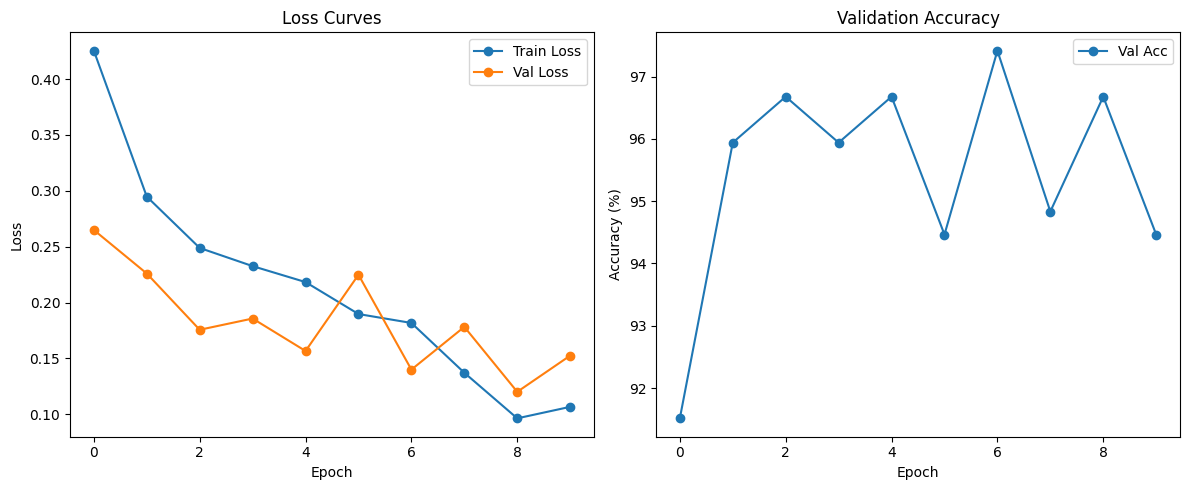

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

train_losses, val_losses, val_accs = [], [], []
best_val_loss = float('inf')
epochs_no_improve = 0
os.makedirs('models', exist_ok=True)

for epoch in range(1, max_epochs+1):
    #Training
    model.train()
    running_loss = 0.0
    for imgs, labels in dataloaders['train']:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(dataloaders['train'])
    train_losses.append(train_loss)

    #Validation
    model.eval()
    running_val_loss = 0.0
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in dataloaders['val']:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            running_val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_loss = running_val_loss / len(dataloaders['val'])
    val_acc  = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.2f}%")

    #Early stopping
    best_val_loss, epochs_no_improve = early_stop(
        val_loss, best_val_loss, epochs_no_improve, model, best_model_path
    )
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

#Load best model
model.load_state_dict(torch.load(best_model_path))
torch.cuda.empty_cache()
print("Loaded best model.")

#Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses,   label='Val Loss',   marker='o')
plt.title('Loss Curves')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Acc', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.tight_layout()
plt.show()

##**Evaluation**

###Pruning evaluation

Prune 0% → Val Acc: 94.46%
Prune 10% → Val Acc: 95.94%
Prune 20% → Val Acc: 95.20%


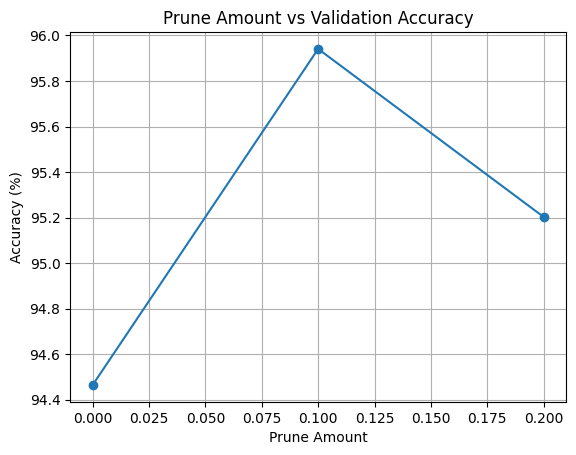

In [ ]:
drop_acc = []
for amt in prune_amounts:
    if amt == 0.0:
        acc = 100 * correct / total
    else:
        pruned = clone_and_prune(model, amt)
        pruned.to(device)
        correct_p, total_p = 0, 0
        with torch.no_grad():
            for imgs, labels in dataloaders['val']:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = pruned(imgs).argmax(dim=1)
                total_p += labels.size(0)
                correct_p += (preds == labels).sum().item()
        acc = 100 * correct_p / total_p
    drop_acc.append(acc)
    print(f"Prune {int(amt*100)}% → Val Acc: {acc:.2f}%")

plt.figure()
plt.plot(prune_amounts, drop_acc, marker='o')
plt.title('Prune Amount vs Validation Accuracy')
plt.xlabel('Prune Amount')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

###Clustering evaluation


KMeans Results:
  Silhouette Score: 0.0576
  Clusters: 9
  Cluster Balance: 0.5645

GMM+PCA Results:
  Silhouette Score: 0.0825
  Clusters: 9
  Cluster Balance: 1.4898

SEGMENTATION COMPARISON
KMeans          | Silhouette: 0.0576 | Clusters:  9 | Balance: 0.564
GMM             | Silhouette: 0.0825 | Clusters:  9 | Balance: 1.490
Best Method: GMM (Score: 0.0825)

KMeans (Samples) Results:
  Silhouette Score: 0.0936
  Clusters: 9
  Cluster Balance: 0.6012

GMM+PCA (Samples) Results:
  Silhouette Score: 0.1824
  Clusters: 8
  Cluster Balance: 1.6569

SEGMENTATION COMPARISON
KMeans          | Silhouette: 0.0936 | Clusters:  9 | Balance: 0.601
GMM             | Silhouette: 0.1824 | Clusters:  8 | Balance: 1.657
Best Method: GMM (Score: 0.1824)

 Individual Sample Analysis:

Image 0:
  KMeans: 9 segments
  GMM:    8 segments

Image 29:
  KMeans: 9 segments
  GMM:    8 segments

Image 99:
  KMeans: 9 segments
  GMM:    8 segments


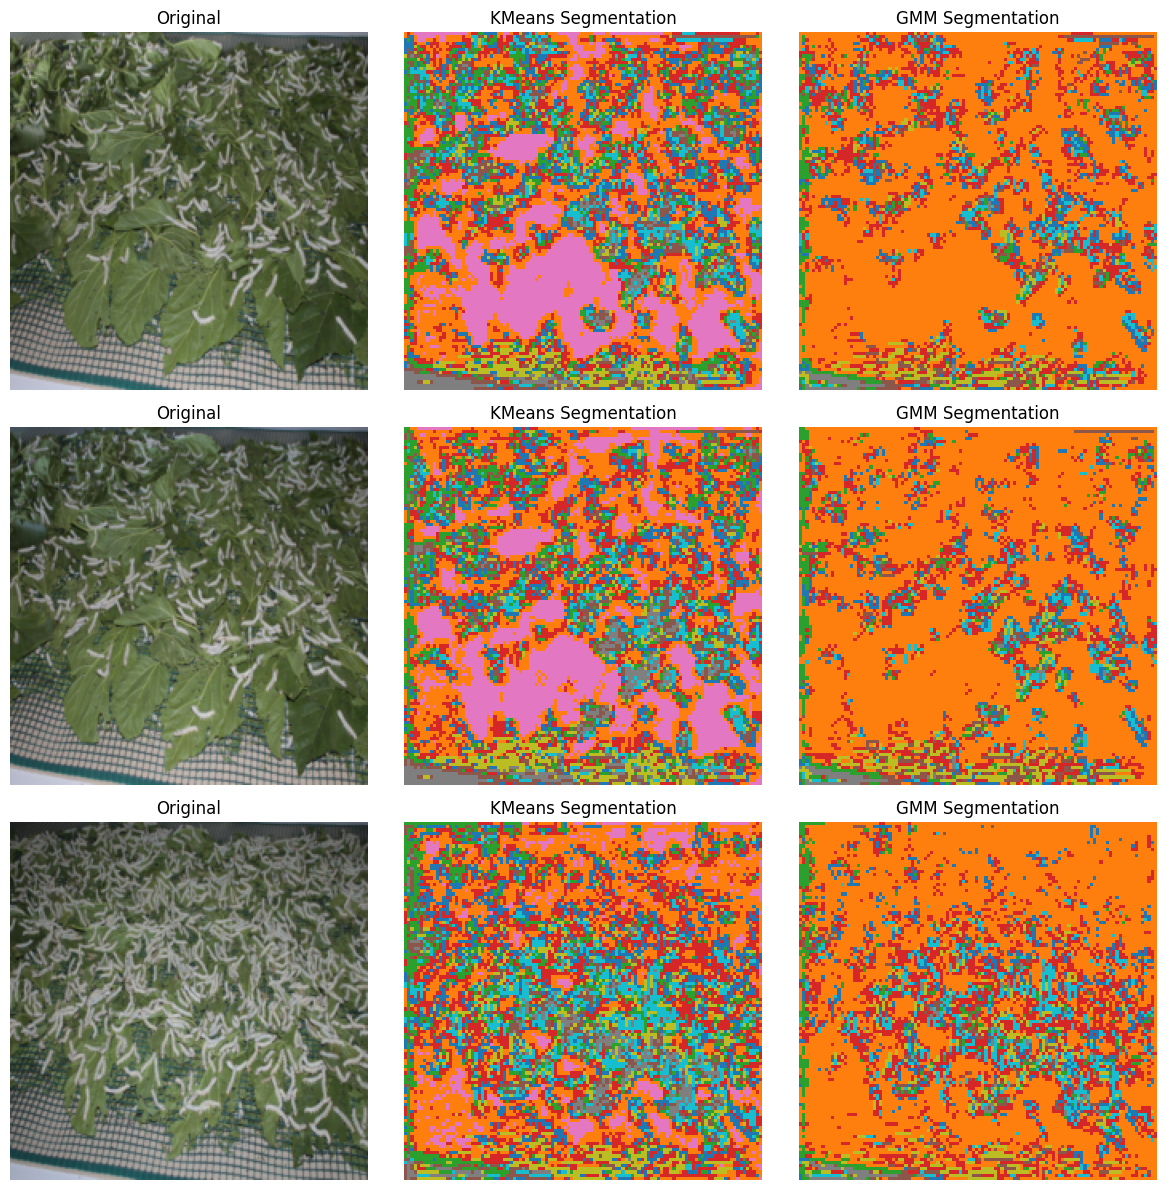

In [ ]:
features_spatial = []

with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device)
        feat = extract_features(model, images)  # [B, C, H, W]
        B, C, H, W = feat.shape
        feat_flat = feat.permute(0, 2, 3, 1).reshape(-1, C)
        features_spatial.append(feat_flat.cpu().numpy())

features = np.concatenate(features_spatial, axis=0)

#Randomly sample 5000 features to reduce computational cost
N = 5000
idx_sample = np.random.choice(features.shape[0], size=N, replace=False)
features_sampled = features[idx_sample]

#Dimensionality reduction with PCA
pca = PCA(n_components=10)
features_reduced = pca.fit_transform(features_sampled)

#Kmeans and GMM clustering
kmeans = KMeans(n_clusters=9, random_state=42)
gmm = GaussianMixture(n_components=9, covariance_type='tied', random_state=42)

kmeans_labels = kmeans.fit_predict(features_reduced)
gmm_labels = gmm.fit_predict(features_reduced)

#Evaluation
kmeans_results = evaluate_segmentation_quality(features_reduced, kmeans_labels, "KMeans")
gmm_results = evaluate_segmentation_quality(features_reduced, gmm_labels, "GMM+PCA")

results = {
    'KMeans': kmeans_results,
    'GMM': gmm_results
}
best = compare_methods(results)

#Global segmentation
features_reduced_full = pca.transform(features)
kmeans_labels_full = kmeans.predict(features_reduced_full)
gmm_labels_full = gmm.predict(features_reduced_full)

#Local segmentation
indices = [0, 29, 99]
selected_imgs = [dataset[i][0] for i in indices]
selected_imgs_tensor = torch.stack(selected_imgs).to(device)

with torch.no_grad():
    feat = extract_features(model, selected_imgs_tensor)  # [B, C, H, W]
    edges = sobel_filter(feat)
    feat_augmented = torch.cat([feat, edges], dim=1)

B, C_aug, H, W = feat_augmented.shape
feat_flat = feat_augmented.permute(0, 2, 3, 1).reshape(-1, C_aug).cpu().numpy()

pca = PCA(n_components=10)
features_reduced_local = pca.fit_transform(feat_flat)

kmeans_masks = KMeans(n_clusters=9, random_state=42).fit_predict(features_reduced_local).reshape(B, H, W)
gmm_masks = GaussianMixture(n_components=9, covariance_type='tied', random_state=42).fit_predict(features_reduced_local).reshape(B, H, W)

kmeans_sample_results = evaluate_segmentation_quality(features_reduced_local, kmeans_masks.flatten(), "KMeans (Samples)")
gmm_sample_results = evaluate_segmentation_quality(features_reduced_local, gmm_masks.flatten(), "GMM+PCA (Samples)")

sample_results = {
    'KMeans': kmeans_sample_results,
    'GMM': gmm_sample_results
}
best_sample = compare_methods(sample_results)

# Images visualization
print("\n Individual Sample Analysis:")
for i in range(B):
    print(f"\nImage {indices[i]}:")
    print(f"  KMeans: {len(np.unique(kmeans_masks[i]))} segments")
    print(f"  GMM:    {len(np.unique(gmm_masks[i]))} segments")

fig, axes = plt.subplots(B, 3, figsize=(12, 4 * B))

for i in range(B):
    orig = selected_imgs[i].permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(kmeans_masks[i], cmap='tab10')
    axes[i, 1].set_title("KMeans Segmentation")
    axes[i, 2].imshow(gmm_masks[i], cmap='tab10')
    axes[i, 2].set_title("GMM Segmentation")
    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()
